# Azure Cognitive Services: Custom Vision

  References: 
  * Portal: [https://www.customvision.ai/](https://www.customvision.ai/)
  * SDK: [https://docs.microsoft.com/pt-br/azure/cognitive-services/custom-vision-service/quickstarts/image-classification?tabs=visual-studio&pivots=programming-language-python](https://docs.microsoft.com/pt-br/azure/cognitive-services/custom-vision-service/quickstarts/image-classification?tabs=visual-studio&pivots=programming-language-python)
  * APIs:
    - Custom Vision Training: [https://westus2.dev.cognitive.microsoft.com/docs/services/Custom_Vision_Training_3.3/](https://westus2.dev.cognitive.microsoft.com/docs/services/Custom_Vision_Training_3.3/)
    - Custom Vision Prediction: [https://eastus.dev.cognitive.microsoft.com/docs/services/Custom_Vision_Prediction_3.1/](https://eastus.dev.cognitive.microsoft.com/docs/services/Custom_Vision_Prediction_3.1/)
  * This code was adapted from [AI-102-AIEngineer: 17-image-classification](https://github.com/MicrosoftLearning/AI-102-AIEngineer/tree/master/17-image-classification)


In [1]:
!pip install azure-cognitiveservices-vision-customvision
!pip install pyyaml

In [2]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region
from msrest.authentication import ApiKeyCredentials
import time
from sklearn import metrics
import requests
import os
import yaml
import json
import numpy as np
import matplotlib.pyplot as plt
import itertools
import time
from sklearn.metrics import confusion_matrix
import uuid


## Lab 1 - First Model Training

### Step 1: Load configs

In [3]:
%run ..\Utils\utils.py
%run ..\Utils\utils-cv.py

In [4]:
config = load_configs(os.path.join("Config", "config.yaml"))

train_endpoint = config['cv']['TrainingEndpoint']
training_key = config['cv']['TrainingKey']
pred_endpoint = config['cv']['PredictionEndpoint']
prediction_key = config['cv']['PredictionKey']
prediction_resource_id = "/subscriptions/8d47f388-3a7a-4970-9dec-2c6cc53e02a9/resourceGroups/rg_chihuahua_muffin/providers/Microsoft.CognitiveServices/accounts/cmcustomvision-prediction"
project_name = config['cv']['ProjectName']

publish_iteration_name = str(uuid.uuid1())
path_training_images = os.path.join(get_project_dir(), "Deploy", "training-images")


Authenticate the client

In [5]:
cv = CustomVisionProject()
trainer = cv.get_trainer(training_key, train_endpoint)
predictor = cv.get_predictor(prediction_key, pred_endpoint)

In [8]:
##
#cv.get_project(project_id)
#print(cv.project.id)

Check the current Custom Vision projects

In [9]:
[i['name'] for i in cv.get_projects()]

['fruit-classifier-gerdau',
 'fruit-classifier-10',
 'fruit-classifier7',
 'fruit-classifier6 (1)',
 'sucatas4',
 'fruit-classifier4 (2)',
 'fruit-classifier4',
 'fruit-classifier3',
 'fruit-classifier2',
 'chihuahua-muffin']

In [10]:
#trainer.unpublish_iteration(project.id, iteration.id)
#trainer.delete_project(trainer.get_projects()[0].id)
cv.create_project(project_name)

print(cv.project.id)


Creating project...
1bc40d6a-bd2c-46fe-b734-15bb03bf6a79


In [11]:
config_relat_path = os.path.join("Config", "config.yaml")
config_path = os.path.join(project_path(), config_relat_path)
update_project_id_config(config_path, cv.project.id)
config = load_configs(config_path)
project_id = config['cv']['ProjectID']

In [12]:
[i['name'] for i in cv.get_projects()]

['fruit-classifier-gerdau-new',
 'fruit-classifier-gerdau',
 'fruit-classifier-10',
 'fruit-classifier7',
 'fruit-classifier6 (1)',
 'sucatas4',
 'fruit-classifier4 (2)',
 'fruit-classifier4',
 'fruit-classifier3',
 'fruit-classifier2',
 'chihuahua-muffin']

### Step 3: Add tags to the project


In [13]:
tags = get_dir_names(path_training_images)
print(tags)

['apple', 'banana', 'orange']


In [14]:
cv.get_tags()

[]

In [15]:
cv.create_tags(tags)

In [16]:
cv.get_tags()

['apple', 'orange', 'banana']

### Step 4: Upload images


In [17]:
cv.upload_local_images(path_training_images)

Uploading images...
Uploading 'apple' images:
Image IMG_20200229_164759.jpg sucessfully uploaded!
Image IMG_20200229_164760.jpg sucessfully uploaded!
Image IMG_20200229_164804.jpg sucessfully uploaded!
Image IMG_20200229_164811.jpg sucessfully uploaded!
Image IMG_20200229_164819.jpg sucessfully uploaded!
Image IMG_20200229_164823.jpg sucessfully uploaded!
Image IMG_20200229_164830.jpg sucessfully uploaded!
Image IMG_20200229_164851.jpg sucessfully uploaded!
Image IMG_20200229_164901.jpg sucessfully uploaded!
Image IMG_20200229_164918.jpg sucessfully uploaded!
Image IMG_20200229_164919.jpg sucessfully uploaded!
Image IMG_20200229_164925.jpg sucessfully uploaded!
Image IMG_20200229_164926jpg.jpg sucessfully uploaded!
Image IMG_20200229_164932.jpg sucessfully uploaded!
Image IMG_20200229_164936.jpg sucessfully uploaded!
Uploading images...
Uploading 'orange' images:
Image IMG_20200229_165108.jpg sucessfully uploaded!
Image IMG_20200229_165112.jpg sucessfully uploaded!
Image IMG_20200229_1

### Step 5: Train Model

In [18]:
iteration = cv.train_model()

Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Completed ...
Model trained!
Iteration id: 56732c1f-8c5c-4a03-a86c-405f641d3a4a
Iteration name: Iteration 1


In [19]:
iteration_id = cv.get_iteration_id()

### Step 6: Model Evaluation


In [24]:
training_results = cv.trainer.get_image_performances(project_id, iteration_id,raw=True).response.json()
total_imgs = cv.trainer.get_tagged_image_count(project_id)

y_true = []
y_pred = []
for i in training_results:
    y_pred.append(i["predictions"][0]["tagName"])
    y_true.append(i["tags"][0]["tagName"]) 

print(y_true)
print(y_pred)

print("\nTotal Images: " + str(total_imgs))
print("Trained Images: " + str(len(training_results)))
print("Splitted Train/Test: {}/{}".format(str(100-int(len(training_results)*100/total_imgs)),str(int(len(training_results)*100/total_imgs))))

['banana', 'banana', 'banana', 'orange', 'orange', 'orange', 'apple', 'apple', 'apple']
['banana', 'banana', 'banana', 'orange', 'orange', 'orange', 'apple', 'apple', 'apple']

Total Images: 45
Trained Images: 9
Splitted Train/Test: 80/20


In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


              precision    recall  f1-score   support

       apple       1.00      1.00      1.00         3
      banana       1.00      1.00      1.00         3
      orange       1.00      1.00      1.00         3

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

Confusion matrix, without normalization
[[3 0 0]
 [0 3 0]
 [0 0 3]]
Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


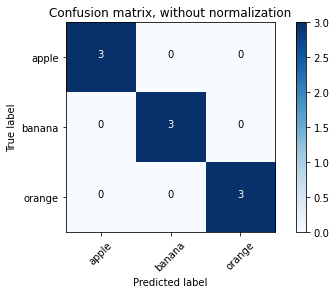

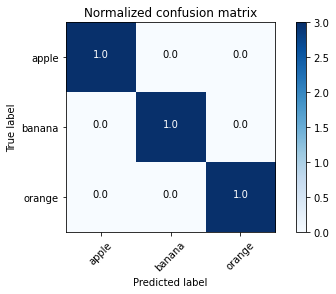

In [26]:
print(metrics.classification_report(y_true, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names = sorted(set(y_true))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Step 7: Publish the current iteration


In [ ]:
cv.trainer.publish_iteration(cv.project.id, iteration_id, publish_iteration_name, prediction_resource_id)

### Step 8: Test the prediction endpoint


In [120]:
# Classify test images
test_img_dir = os.path.join(get_project_dir(),'Deploy','test-images')
print(test_img_dir)

results = []
for image in os.listdir(test_img_dir):
    image_data = open(os.path.join(test_img_dir,image), "rb").read()
    result = (cv.predictor.classify_image(cv.project.id, cv.get_iteration_publis_name(), image_data))
    #print(result)
    results.append(result)
    print(image, ': {} ({:.0%})'.format(result.predictions[0].tag_name, result.predictions[0].probability))
print("{} images uploaded".format(len(results)))


c:\Users\anacarolines\OneDrive - Microsoft\Projetos\customvision-operations - Copy\Deploy\test-images
IMG_TEST_1.jpg : apple (100%)
IMG_TEST_2.jpg : banana (100%)
IMG_TEST_3.jpg : orange (100%)
IMG_TEST_4.jpg : apple (58%)
4 images uploaded


In [ ]:
 # Loop over each label prediction and print any with probability > 50% voltar
i = 0 
threshold = 0.8
for r in results:
    for prediction in r.predictions:
        if prediction.probability > threshold:
            i = i+1
print("{} images with probability > than {}.".format(i,threshold))
